In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from DataLoader import DataLoader
import datetime
import random
import warnings
from BehaviourFeatureExtractor import BehaviourFeatureExtractor, plot_mouse_angle_to_pup

## Reading and loading data ##

In [2]:
data_dir = "data"
DL = DataLoader(data_dir, path_to_config_file = "config.json")

Found items ['.DS_Store', 'MBI5335RR'] at directory data
Found items ['.DS_Store', 'MBI5335RR_240309_d6', 'MBI5335RR_240305_d2', 'MBI5335RR_240304_d1', 'MBI5335RR_240308_d5', 'MBI5335RR_240306_d3', 'MBI5335RR_240307_d4'] at directory data/MBI5335RR
Found items ['MBI5335RR_240309_d6_Avisoft', 'MBI5335RR_240309_d6_Behavior'] at directory data/MBI5335RR/MBI5335RR_240309_d6
Found items ['MBI5335RR_240309_d6_Avisoft_concatenated 2024-04-21  2_08 PM_Stats_SYNCCORRECTED.xlsx'] at directory data/MBI5335RR/MBI5335RR_240309_d6/MBI5335RR_240309_d6_Avisoft
Found items ['MBI5335RR_d6DLC_resnet50_ESM-maternal-learningJun18shuffle1_100000.csv', 'MBI5335RR_240309_d6_BehavSummary.csv'] at directory data/MBI5335RR/MBI5335RR_240309_d6/MBI5335RR_240309_d6_Behavior
Found items ['MBI5335RR_240305_d2_Behavior', 'MBI5335RR_240305_d2_Avisoft'] at directory data/MBI5335RR/MBI5335RR_240305_d2
Found items ['MBI5335RR_240305_d2_BehavSummary.csv', 'MBI5335RR_d2DLC_resnet50_ESM-maternal-learningJun18shuffle1_100000.

## Data Exploration ##

##### Day 1 trials #####

In [3]:
# get data for d1 experiment
day1_data = DL.get_data_for_experiment(mouse_id = "MBI5335RR",
                                       day = "d1")

# fill out dataframes
df_summary = day1_data['Behavior']['df_summary']
df_DLC = day1_data['Behavior']['df_dlc']

In [4]:
BF = BehaviourFeatureExtractor("config.json")
df_DLC_updated, trials_dict = BF.extract_base_parameters(df_DLC, df_summary)

Processing trial 1 Start frame: 11072 End frame: 11538
Trial 1 started at 0:06:09.082000 and ended at 0:06:24.586000
Trial 1 started at 369.082 and ended at 384.586
----> Interpolating low likelihood values
----> Computing speed
----> Computing distance to pup
----> Computing head angle to pup
Processing trial 2 Start frame: 11901 End frame: 12085
Trial 2 started at 0:06:36.698000 and ended at 0:06:42.842000
Trial 2 started at 396.698 and ended at 402.842
----> Interpolating low likelihood values
----> Computing speed
----> Computing distance to pup
----> Computing head angle to pup
Processing trial 3 Start frame: 12456 End frame: 14848
Trial 3 started at 0:06:55.186000 and ended at 0:08:14.930000
Trial 3 started at 415.186 and ended at 494.93
----> Interpolating low likelihood values
----> Computing speed
----> Computing distance to pup
----> Computing head angle to pup
Processing trial 4 Start frame: 15232 End frame: 15940
Trial 4 started at 0:08:27.722000 and ended at 0:08:51.348000

## Feature Extraction ##

### BehavSummary + DLC  ###

- **BehavSummary + DLC**
    - Define behavioral windows (e.g: -2 to +2 seconds of each behavioral event)
    - Define behavioral windows pre-event (e.g: -x to 0 seconds of each behavioral event)
    - Find behavioral events (from BehavSummaries; *timing info*) in the DLC position data (*x,y info*):
        - at each behavioral event, where was the mouse and the pup located in the arena?
            - how far was the mouse from the pup?
            - what was the head direction of the mouse (towards the pup) at that point?
            - ‘approach’ trajectory: parse out trajectory of mouse towards pup and try to find a segment which is more ‘direct’/ higher speed
        - For the pre-event behavioral window of MouseFirstPickUpSecs: what is the speed of the mouse? What is the head direction of the mouse?

In [5]:
BF = BehaviourFeatureExtractor("config.json")

xmax, ymax = BF.config["arena_bounds"]["xmax"], BF.config["arena_bounds"]["ymax"]
xmin, ymin = BF.config["arena_bounds"]["xmin"], BF.config["arena_bounds"]["ymin"]

trial_1_DLC = BF.extract_trial_from_DLC(df_DLC, df_summary, trial_num = 1)

Display full trial

<Axes: xlabel='pup_y'>

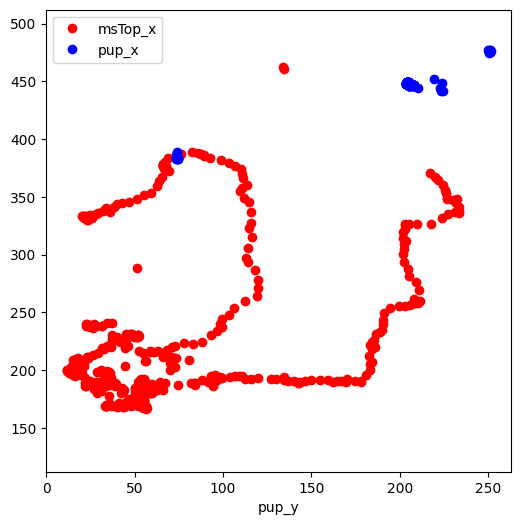

In [6]:
# plot mouse and pup positions
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

trial_1_DLC.plot(x='msTop_y', y='msTop_x', style='o', ax=ax, xlim=(ymin, ymax), ylim=(xmin, xmax), color = 'r')
trial_1_DLC.plot(x='pup_y', y='pup_x', style='o', ax=ax,xlim=(ymin, ymax), ylim=(xmin, xmax), color = 'b')

#### Quality Checks on low likelihood coords ####

Visualization noisy data points and comparing with nest coordinates

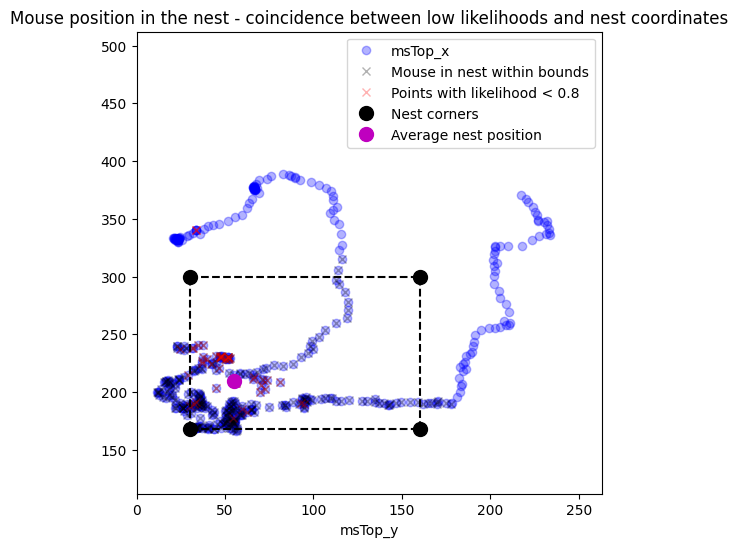

In [13]:
n = 1 # pick n in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# trial_DLC = BF.extract_trial_from_DLC(df_DLC, df_summary, trial_num = n), need to update this method

trial_DLC = trials_dict[n]

threshold = 0.8 # likelihood

trial_DLC_flagged = BF.flag_nest_coordinates(trial_DLC)

# retrieve mask of in_nest coordinates
mask_nest = (trial_DLC_flagged["in_nest"] == True)

# retrieve points with likelihood under 80
mask_low_likelihood = (trial_DLC_flagged["msTop_likelihood"] < threshold)

# plot average of center nest points
nest_avg_x, nest_avg_y = trial_DLC_flagged["centerNest_x"].mean(), trial_DLC_flagged["centerNest_y"].mean()

# plot mouse position and highlight low likelihood points and points in the nest
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

trial_DLC_flagged.plot(x='msTop_y', y='msTop_x', style='o', ax=ax, xlim=(ymin, ymax), ylim=(xmin, xmax), color = 'blue', alpha = 0.3)
trial_DLC_flagged[mask_nest].plot(x='msTop_y', y='msTop_x', style='x', ax=ax, xlim=(ymin, ymax), ylim=(xmin, xmax), color = 'black', alpha = 0.3, label = f"Mouse in nest within bounds")
trial_DLC_flagged[mask_low_likelihood].plot(x='msTop_y', y='msTop_x', style='x', ax=ax, xlim=(ymin, ymax), ylim=(xmin, xmax), color = 'r', alpha = 0.3, label = f"Points with likelihood < {threshold}")

# draw nest bounds in plot
nest_bounds = BF.config["nest_bounds"]

# plot all four nest corners and draw dashed lines between them

# bottom left corner
ax.plot(nest_bounds["ymin"], nest_bounds["xmin"], 'o', color = 'black', markersize = 10, label = "Nest corners")
# bottom right corner
ax.plot(nest_bounds["ymax"], nest_bounds["xmin"], 'o', color = 'black', markersize = 10)
# top left corner
ax.plot(nest_bounds["ymin"], nest_bounds["xmax"], 'o', color = 'black', markersize = 10)
# top right corner
ax.plot(nest_bounds["ymax"], nest_bounds["xmax"], 'o', color = 'black', markersize = 10)

# draw dashed lines between nest corners
ax.plot([nest_bounds["ymin"], nest_bounds["ymax"]], [nest_bounds["xmin"], nest_bounds["xmin"]], 'k--')
ax.plot([nest_bounds["ymin"], nest_bounds["ymax"]], [nest_bounds["xmax"], nest_bounds["xmax"]], 'k--')
ax.plot([nest_bounds["ymin"], nest_bounds["ymin"]], [nest_bounds["xmin"], nest_bounds["xmax"]], 'k--')
ax.plot([nest_bounds["ymax"], nest_bounds["ymax"]], [nest_bounds["xmin"], nest_bounds["xmax"]], 'k--')


# plot the average nest position in magenta
ax.plot(nest_avg_y, nest_avg_x, 'o', color = 'm', markersize = 10, label = "Average nest position")

# add title
ax.set_title("Mouse position in the nest - coincidence between low likelihoods and nest coordinates")

# plot legend
ax.legend()

Visualizing interpolated points

In [ ]:
threshold = 0.3
dict_body_parts_to_coords = BF.DLC_cols

day = "d1"
data = DL.get_data_for_experiment(mouse_id = "MBI5335RR",
                                       day = day)
df_DLC = data['Behavior']['df_dlc']
df_summary = data['Behavior']['df_summary']
n = 3 # pick n in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
trial_DLC = BF.extract_trial_from_DLC(df_DLC, df_summary, trial_num = n)

# print total nans
print(f"Total nans in the trial: {trial_DLC.isna().sum().sum()}")

# print start and end times in minutes from the time_seconds column
trial_start_time = trial_DLC["time_seconds"].iloc[0]
trial_end_time = trial_DLC["time_seconds"].iloc[-1]

print(f"Trial {n} started at {trial_start_time} and ended at {trial_end_time}")

print(f"Trial {n} started at {datetime.timedelta(seconds=trial_start_time)} and ended at {datetime.timedelta(seconds=trial_end_time)}")

trial_DLC_flagged = BF.flag_nest_coordinates(trial_DLC, minimum_distance_to_nest=min_dist)
trial_DLC_flagged_intepolated = BF.filter_low_likelihoods_and_interpolate(trial_DLC_flagged,
                                                                          dict_body_parts_to_coords,
                                                                          threshold=threshold)


mask_nest = trial_DLC_flagged["in_nest"]


for body_part in dict_body_parts_to_coords.keys():

    if type(dict_body_parts_to_coords[body_part]) == dict and "likelihood" in dict_body_parts_to_coords[body_part]:


        mask_interpolated =(trial_DLC_flagged[dict_body_parts_to_coords[body_part]["likelihood"]] < threshold) & (~mask_nest)

        # plot trajectory that was not interpolated in blue, label = "original points with high likelihood or in the nest"

        # create fig
        fig, ax = plt.subplots(1, 3, figsize=(24, 6))

        trial_DLC_flagged.loc[~mask_interpolated].plot(x=dict_body_parts_to_coords[body_part]["y"], y=dict_body_parts_to_coords[body_part]["x"],
                                                       style='o', ax=ax[0], xlim=(ymin, ymax), ylim=(xmin, xmax), color = 'grey', alpha = 0.3, label = "unaffected points")

        # plot original points in red if likelihood is low, label = "original points with low likelihood"
        trial_DLC_flagged.loc[mask_interpolated].plot(x=dict_body_parts_to_coords[body_part]["y"], y=dict_body_parts_to_coords[body_part]["x"],
                                                       style='o', ax=ax[0], xlim=(ymin, ymax), ylim=(xmin, xmax), color = 'red', alpha = 0.3, label = f"original points with likelihood < {threshold}")

        # plot interpolated points in green if likelihood is low and mouse is out of the nest, label = "interpolated points"
        trial_DLC_flagged_intepolated.loc[mask_interpolated].plot(x=dict_body_parts_to_coords[body_part]["y"], y=dict_body_parts_to_coords[body_part]["x"],
                                                       style='o', ax=ax[0], xlim=(ymin, ymax), ylim=(xmin, xmax), color = 'green', alpha = 0.3, label = "interpolated points")
        
        # plot original trajectory

        trial_DLC_flagged[~mask_nest].plot(x=dict_body_parts_to_coords[body_part]["y"], y=dict_body_parts_to_coords[body_part]["x"],
                                             style='o', ax=ax[1], xlim=(ymin, ymax), ylim=(xmin, xmax), color = 'blue', alpha = 0.3, label = "original trajectory")
        
        trial_DLC_flagged[mask_nest].plot(x=dict_body_parts_to_coords[body_part]["y"], y=dict_body_parts_to_coords[body_part]["x"],
                                           style='o', ax=ax[1], xlim=(ymin, ymax), ylim=(xmin, xmax), color = 'magenta', alpha = 0.3, label = "in nest coordinates")
        

        # plot final trajectory
        trial_DLC_flagged_intepolated[~mask_nest].plot(x=dict_body_parts_to_coords[body_part]["y"], y=dict_body_parts_to_coords[body_part]["x"],
                                           style='o', ax=ax[2], xlim=(ymin, ymax), ylim=(xmin, xmax), color = 'blue', alpha = 0.3, label = "final trajectory")
        
        trial_DLC_flagged_intepolated[mask_nest].plot(x=dict_body_parts_to_coords[body_part]["y"], y=dict_body_parts_to_coords[body_part]["x"],
                                           style='o', ax=ax[2], xlim=(ymin, ymax), ylim=(xmin, xmax), color = 'magenta', alpha = 0.3, label = "in nest coordinates")
        

        # mark the first point of the trajectory as a green dot, markersize = 10, label = "start"
        ax[0].plot(trial_DLC_flagged[dict_body_parts_to_coords[body_part]["y"]].iloc[0], trial_DLC_flagged_intepolated[dict_body_parts_to_coords[body_part]["x"]].iloc[0], 'o', color = 'cyan', markersize = 10, label = "start")
        ax[1].plot(trial_DLC_flagged[dict_body_parts_to_coords[body_part]["y"]].iloc[0], trial_DLC_flagged_intepolated[dict_body_parts_to_coords[body_part]["x"]].iloc[0], 'o', color = 'cyan', markersize = 10, label = "start")
        ax[2].plot(trial_DLC_flagged_intepolated[dict_body_parts_to_coords[body_part]["y"]].iloc[0], trial_DLC_flagged_intepolated[dict_body_parts_to_coords[body_part]["x"]].iloc[0], 'o', color = 'cyan', markersize = 10, label = "start")

        # mark the last point of the trajectory as a red dot, markersize = 10, label = "end"
        ax[0].plot(trial_DLC_flagged[dict_body_parts_to_coords[body_part]["y"]].iloc[-1], trial_DLC_flagged_intepolated[dict_body_parts_to_coords[body_part]["x"]].iloc[-1], 'o', color = 'red', markersize = 10, label = "end")
        ax[1].plot(trial_DLC_flagged[dict_body_parts_to_coords[body_part]["y"]].iloc[-1], trial_DLC_flagged_intepolated[dict_body_parts_to_coords[body_part]["x"]].iloc[-1], 'o', color = 'red', markersize = 10, label = "end")
        ax[2].plot(trial_DLC_flagged_intepolated[dict_body_parts_to_coords[body_part]["y"]].iloc[-1], trial_DLC_flagged_intepolated[dict_body_parts_to_coords[body_part]["x"]].iloc[-1], 'o', color = 'red', markersize = 10, label = "end")

        # set title of body part as title of the plot
        ax[0].set_title(body_part)
        ax[1].set_title(body_part+ " original trajectory")
        ax[2].set_title(body_part+ " processed trajectory")

        # plot legend
        ax[0].legend()
        ax[1].legend()     
        ax[2].legend() 





### Computing Base Parameters ###

In [41]:
trial_1_DLC = BF.extract_trial_from_DLC(df_DLC, df_summary, trial_num = 3)
trial_1_DLC = BF.flag_nest_coordinates(trial_1_DLC, minimum_distance_to_nest=40)
trial_1_DLC = BF.filter_low_likelihoods_and_interpolate(trial_1_DLC, dict_body_parts_to_coords, threshold=0.3)
mask = (trial_1_DLC["in_nest"] == False)

Speed

In [ ]:
mouse_speed_col = 'mouse_speed_px/s'
pup_speed_col = 'pup_speed_px/s'

trial_1_DLC = BF.compute_speed(trial_1_DLC, x_col = 'msTop_x', y_col = 'msTop_y', speed_col = mouse_speed_col)
trial_1_DLC = BF.compute_speed(trial_1_DLC, x_col = 'pup_x', y_col = 'pup_y', speed_col = pup_speed_col)

# create a grid of 2 histogram plots one for mouse speed and one for pup speed
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# histogram of speed

trial_1_DLC[mask][mouse_speed_col].hist(bins=50, ax=ax[0], label = 'mouse speed')
trial_1_DLC[mask][pup_speed_col].hist(bins=50, ax=ax[0], label = 'pup speed')
ax[0].set_title('Mouse and pup speed histogram')  # set title
ax[0].legend()  # show legend

# histogram of speed
trial_1_DLC[mask].plot(x='frame_index', y=mouse_speed_col, ax=ax[1], label = 'mouse speed')
trial_1_DLC[mask].plot(x='frame_index', y=pup_speed_col, ax=ax[1], label = 'pup speed')

ax[1].set_title('Speed VS. frame_index')  # set title
ax[1].legend()  # show legend

Distance to pup

In [ ]:
distance_mouse_to_pup = 'distance_mouse_to_pup'
distance_head_to_pup = 'distance_head_to_pup'
head_x_col, head_y_col = 'endHeadbar_x','endHeadbar_y'

trial_1_DLC = BF.compute_distance_to_pup(trial_1_DLC, distance_col = distance_mouse_to_pup)
trial_1_DLC  = BF.compute_distance_to_pup(trial_1_DLC, distance_col = distance_head_to_pup, x_col = head_x_col, y_col = head_y_col)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

trial_1_DLC[mask][distance_mouse_to_pup].hist(bins=20, ax=ax, label = 'mouse')
trial_1_DLC[mask][distance_head_to_pup].hist(bins=20, ax=ax, label = 'head')

ax.legend()

ax.set_title('Distance to pup')  # set title
ax.set_xlabel('Distance (px)')  # set x label

Head angle to pup

In [ ]:
head_angle_to_pup_col = 'head_angle_to_pup_degrees'

trial_1_DLC = BF.compute_head_angle_to_pup(trial_1_DLC, add_vector_columns = True, head_angle_to_pup_col=head_angle_to_pup_col)

trial_1_DLC[mask][head_angle_to_pup_col].hist(bins=20)
# set title
plt.title('Mouse head angle to pup histogram')
plt.xlabel('Angle (degrees)')  # set x-axis label

Visualize head angle to pup

In [ ]:
plot_mouse_angle_to_pup(trial_1_DLC, ylim = 300 , xlim = 600)

Process full file (df_DLC)

In [ ]:
df_DLC_updated, trials_dict = BF.extract_base_parameters(df_DLC, df_summary)

In [ ]:
df_DLC_updated.head(3)

In [ ]:
print("Elements of trials_dict:", trials_dict.keys())
trials_dict[1].head(3)

## Detecting higher level behaviours ##

Carrying

Approach

Crouching/Sniffing/Licking/Grooming

# Behavioural windows #

### Behavioural Windows (+/- 2s) around key events ###

In [21]:
def extract_feature_behavioural_window(behaviour_col, trial_num, df_DLC, df_summary, window_size = 60):

    # get the trial
    trial_metadata = df_summary[df_summary['TrialNum'] == trial_num]
    BehavRecdTrialEndSecs = trial_metadata['BehavRecdTrialEndSecs'].values[0]

    # nan check
    if np.isnan(BehavRecdTrialEndSecs):
        warnings.warn("BehavRecdTrialEndSecs is NaN")
        return None
    
    end_frame = BF.convert_seconds_to_frame(BehavRecdTrialEndSecs)
    start_frame = end_frame - window_size

    pass
    # return a slice of the dataframe with the features speed, head_angle, distance to pup, extracted

### Pre-event behavioural window (-Xs preceding key event) ###

In [22]:
def extract_feature_pre_event_window(behaviour_col, trial_num, df_DLC, df_summary, pre_event_window_size = 100):

    pass

### Analyzing parameters ###

In [23]:
def analyze_trajectory(df_DLC, start_frame, end_frame):
    
    print("Trajectory detected from frame {} to frame {}".format(start_frame, end_frame))
    